# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [1]:
# --- import libraries ---
import pandas as pd
import numpy as np
import sys
import re
import pickle
import nltk

from sqlalchemy import create_engine

from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection  import GridSearchCV
from sklearn import multioutput

from custom_transformer import StartingVerbExtractor

import matplotlib.pyplot as plt
%matplotlib inline
# ------------------------

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [2]:
# disable warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
# download nltk packages
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [4]:
# load data from database
engine = create_engine('sqlite:///InsertDatabaseName.db')
df = pd.read_sql_table('InsertTableName', engine)

# drop nan values
df.dropna(axis=0, how = 'any', inplace = True)

X = df['message']
Y = df.iloc[:,4:].astype(int)

In [5]:
Y.head(5)

,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,child_alone,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,1,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 2. Write a tokenization function to process your text data

In [6]:
def tokenize(text):
    '''
    Receives as input raw text which afterwards normalized, stop words removed, 
    stemmed and lemmatized.
    
    @param : text - input raw text
    @return: clean_tokens - tokenized text as result
    '''

    tokens = word_tokenize(text)
    lemmatizer = WordNetLemmatizer()

    clean_tokens = []
    
    for token in tokens:
        clean_token = lemmatizer.lemmatize( token ).lower().strip()
        
        clean_tokens.append(clean_token)
    # --- for ---

    return clean_tokens

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0157f3a358>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f0157d71fd0>]], dtype=object)

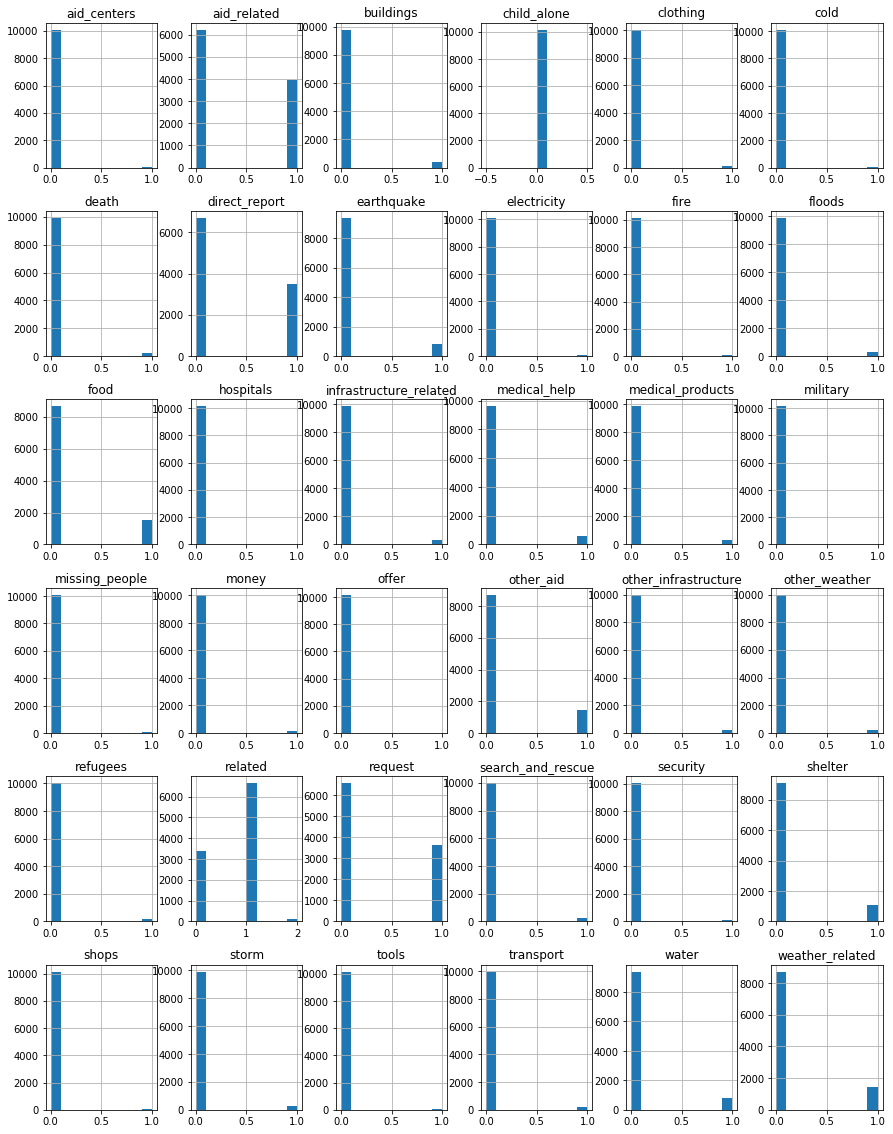

In [7]:
# let's take a look to the possible values distribution within classes

# making size of figure bigger
fig = plt.figure(figsize = (15,20))
ax  = fig.gca()

# plot the historgram
Y.hist(ax = ax)

### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [8]:
# creating a pipeline
pipeline_rf = Pipeline([
                    ('vect', CountVectorizer(tokenizer=tokenize)),
                    ('tfidf', TfidfTransformer()),
                    ('clf', MultiOutputClassifier( RandomForestClassifier() ))
                   ])

### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [9]:
# split data into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split( X, Y, random_state = 42 )

In [10]:
# train classifier: pipeline
rf_model = pipeline_rf.fit( X_train, Y_train )

### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [11]:
def generate_report(y_test, y_pred):
    '''
    Receives as input raw text which afterwards normalized, stop words removed, 
    stemmed and lemmatized.
    
    @param : y_test - test value
    @param : y_pred - prediction value
    @return: df - DataFrame as result
    '''
    
    metrics = []
    
    for i, column in enumerate( Y.columns.values ):
        accuracy  = accuracy_score(y_test[:,i], y_pred[:,i])
        precision = precision_score(y_test[:,i], y_pred[:,i], average='micro')
        recall    = recall_score(y_test[:,i], y_pred[:,i], average='micro')
        f1        = f1_score(y_test[:,i], y_pred[:,i], average='micro')
        
        metrics.append([accuracy, precision, recall, f1])
    # --- for ---
    
    # create dataframe as result
    df = pd.DataFrame( data = np.array(metrics),
                      index=Y.columns.values, 
                      columns=['Accuracy', 'Precision', 'Recall', 'F1 score'] )
    return df

In [12]:
# evaluate the training set
Y_train_pred = pipeline_rf.predict( X_train )

In [13]:
# generate report for each row - training
df_train_report_pipeline_rf = generate_report( np.array(Y_train), Y_train_pred )
df_train_report_pipeline_rf

,Accuracy,Precision,Recall,F1 score
related,0.988724,0.988724,0.988724,0.988724
request,0.988724,0.988724,0.988724,0.988724
offer,0.999476,0.999476,0.999476,0.999476
aid_related,0.990298,0.990298,0.990298,0.990298
medical_help,0.990167,0.990167,0.990167,0.990167
medical_products,0.994231,0.994231,0.994231,0.994231
search_and_rescue,0.995018,0.995018,0.995018,0.995018
security,0.995804,0.995804,0.995804,0.995804
military,0.998951,0.998951,0.998951,0.998951
child_alone,1.000000,1.000000,1.000000,1.000000


In [14]:
# calculate the mean values for each column
mean = df_train_report_pipeline_rf.mean(axis=0)
mean

Accuracy     0.994825
Precision    0.994825
Recall       0.994825
F1 score     0.994825
dtype: float64

In [15]:
Y_test_pred = pipeline_rf.predict( X_test )

In [16]:
# generate report for each row - testing
df_test_report_pipeline_rf = generate_report( np.array(Y_test), Y_test_pred )
df_test_report_pipeline_rf

,Accuracy,Precision,Recall,F1 score
related,0.739284,0.739284,0.739284,0.739284
request,0.802202,0.802202,0.802202,0.802202
offer,0.999214,0.999214,0.999214,0.999214
aid_related,0.777035,0.777035,0.777035,0.777035
medical_help,0.946913,0.946913,0.946913,0.946913
medical_products,0.970507,0.970507,0.970507,0.970507
search_and_rescue,0.984271,0.984271,0.984271,0.984271
security,0.983877,0.983877,0.983877,0.983877
military,0.994888,0.994888,0.994888,0.994888
child_alone,1.000000,1.000000,1.000000,1.000000


In [17]:
# calculate the mean values for each column
mean = df_test_report_pipeline_rf.mean(axis=0)
mean

Accuracy     0.950966
Precision    0.950966
Recall       0.950966
F1 score     0.950966
dtype: float64

In [18]:
# create new dataframe for test report results
df_test_report_mean = pd.DataFrame()

# collect test report
df_test_report_mean = df_test_report_mean.append( mean, ignore_index=True )
last_idx = df_test_report_mean.shape[0]-1
df_test_report_mean.loc[last_idx,'Name'] = 'RandomForrest'

df_test_report_mean

,Accuracy,F1 score,Precision,Recall,Name
0,0.950966,0.950966,0.950966,0.950966,RandomForrest


### 6. Improve your model
Use grid search to find better parameters. 

In [19]:
parameters = {
    'vect__min_df': [1, 5],
    'tfidf__use_idf':[True, False],
    'clf__estimator__n_estimators':[10, 25], 
    'clf__estimator__min_samples_split':[2, 5, 10]
}

cv = GridSearchCV( pipeline_rf, param_grid=parameters )

### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

In [20]:
# train classifier
cv_model = cv.fit( X_train, Y_train )

In [21]:
cv.best_params_

{'clf__estimator__min_samples_split': 10,
 'clf__estimator__n_estimators': 25,
 'tfidf__use_idf': True,
 'vect__min_df': 5}

In [22]:
Y_test_pred_cv = cv.predict( X_test )

In [23]:
# generate report for each row - testing
df_test_report_pipeline_cv = generate_report( np.array(Y_test), Y_test_pred_cv )
df_test_report_pipeline_cv

,Accuracy,Precision,Recall,F1 score
related,0.767991,0.767991,0.767991,0.767991
request,0.831695,0.831695,0.831695,0.831695
offer,0.999214,0.999214,0.999214,0.999214
aid_related,0.815179,0.815179,0.815179,0.815179
medical_help,0.947306,0.947306,0.947306,0.947306
medical_products,0.972473,0.972473,0.972473,0.972473
search_and_rescue,0.985057,0.985057,0.985057,0.985057
security,0.983877,0.983877,0.983877,0.983877
military,0.994888,0.994888,0.994888,0.994888
child_alone,1.000000,1.000000,1.000000,1.000000


In [24]:
# calculate the mean values for each column
mean = df_test_report_pipeline_cv.mean(axis=0)
mean

Accuracy     0.957705
Precision    0.957705
Recall       0.957705
F1 score     0.957705
dtype: float64

In [25]:
# collect test report
df_test_report_mean = df_test_report_mean.append( mean, ignore_index=True )
last_idx = df_test_report_mean.shape[0]-1
df_test_report_mean.loc[last_idx,'Name'] = 'cv'

df_test_report_mean

,Accuracy,F1 score,Precision,Recall,Name
0,0.950966,0.950966,0.950966,0.950966,RandomForrest
1,0.957705,0.957705,0.957705,0.957705,cv


### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

In [26]:
pipeline_ada = Pipeline([
                        ('vect', CountVectorizer(tokenizer=tokenize)),
                        ('tfidf', TfidfTransformer()),
                        ('clf', MultiOutputClassifier( AdaBoostClassifier() ))
                       ])

parameters_ada = {'vect__min_df': [5],
                  'tfidf__use_idf':[True],
                  'clf__estimator__learning_rate': [0.5, 1], 
                  'clf__estimator__n_estimators':[10, 25]
                 }

cv_ada = GridSearchCV( pipeline_ada, param_grid=parameters_ada )

In [27]:
AdaBoostClassifier().get_params()

{'algorithm': 'SAMME.R',
 'base_estimator': None,
 'learning_rate': 1.0,
 'n_estimators': 50,
 'random_state': None}

In [28]:
# train classifier
cv_ada_model = cv_ada.fit( X_train, Y_train )

In [29]:
Y_test_pred_ada = cv_ada.predict( X_test )

In [30]:
# generate report for each row - testing
df_test_report_pipeline_ada = generate_report( np.array(Y_test), Y_test_pred_ada )
df_test_report_pipeline_ada

,Accuracy,Precision,Recall,F1 score
related,0.697601,0.697601,0.697601,0.697601
request,0.832088,0.832088,0.832088,0.832088
offer,0.999214,0.999214,0.999214,0.999214
aid_related,0.814786,0.814786,0.814786,0.814786
medical_help,0.948879,0.948879,0.948879,0.948879
medical_products,0.973260,0.973260,0.973260,0.973260
search_and_rescue,0.983091,0.983091,0.983091,0.983091
security,0.983091,0.983091,0.983091,0.983091
military,0.994495,0.994495,0.994495,0.994495
child_alone,1.000000,1.000000,1.000000,1.000000


In [31]:
# calculate the mean values for each column
mean = df_test_report_pipeline_ada.mean(axis=0)
mean

Accuracy     0.956362
Precision    0.956362
Recall       0.956362
F1 score     0.956362
dtype: float64

In [32]:
# collect test report
df_test_report_mean = df_test_report_mean.append( mean, ignore_index=True )
last_idx = df_test_report_mean.shape[0]-1
df_test_report_mean.loc[last_idx,'Name'] = 'ada'

df_test_report_mean

,Accuracy,F1 score,Precision,Recall,Name
0,0.950966,0.950966,0.950966,0.950966,RandomForrest
1,0.957705,0.957705,0.957705,0.957705,cv
2,0.956362,0.956362,0.956362,0.956362,ada


<hr>

In [33]:
# trying to add another feature.
pipeline_rf2 = Pipeline([ 
                        ('features', FeatureUnion ([
                            ('text_pipeline', Pipeline ([
                                    ('vect',  CountVectorizer(tokenizer=tokenize)),
                                    ('tfidf', TfidfTransformer())
                                                        ])),      
                            ('starting_verb', StartingVerbExtractor() )
                            ])),
                        ('clf', multioutput.MultiOutputClassifier( RandomForestClassifier() ))
                        ])

In [34]:
# train classifier
rf_model2 = pipeline_rf2.fit( X_train, Y_train )

In [35]:
Y_test_pred_rf2 = pipeline_rf2.predict( X_test )

In [36]:
# generate report for each row - testing
df_test_report_pipeline_rf2 = generate_report( np.array(Y_test), Y_test_pred_rf2 )
df_test_report_pipeline_rf2

,Accuracy,Precision,Recall,F1 score
related,0.756193,0.756193,0.756193,0.756193
request,0.804168,0.804168,0.804168,0.804168
offer,0.999214,0.999214,0.999214,0.999214
aid_related,0.777428,0.777428,0.777428,0.777428
medical_help,0.947306,0.947306,0.947306,0.947306
medical_products,0.969721,0.969721,0.969721,0.969721
search_and_rescue,0.984271,0.984271,0.984271,0.984271
security,0.983484,0.983484,0.983484,0.983484
military,0.994888,0.994888,0.994888,0.994888
child_alone,1.000000,1.000000,1.000000,1.000000


In [37]:
# calculate the mean values for each column
mean = df_test_report_pipeline_rf2.mean(axis=0)
mean

Accuracy     0.950572
Precision    0.950572
Recall       0.950572
F1 score     0.950572
dtype: float64

In [38]:
# collect test report
df_test_report_mean = df_test_report_mean.append( mean, ignore_index=True )
last_idx = df_test_report_mean.shape[0]-1
df_test_report_mean.loc[last_idx,'Name'] = 'RandomForrest2'

df_test_report_mean

,Accuracy,F1 score,Precision,Recall,Name
0,0.950966,0.950966,0.950966,0.950966,RandomForrest
1,0.957705,0.957705,0.957705,0.957705,cv
2,0.956362,0.956362,0.956362,0.956362,ada
3,0.950572,0.950572,0.950572,0.950572,RandomForrest2


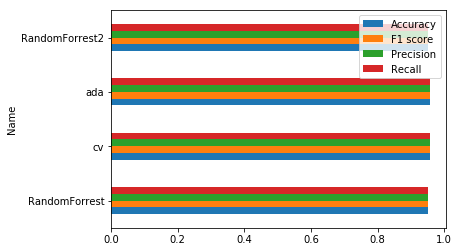

In [39]:
# plot the report
df_test_report_mean.set_index('Name', inplace=True)
df_test_report_mean.plot.barh()

<hr>

### 9. Export your model as a pickle file

In [40]:
# I choose the model with AdaBoost classifier
with open('classifer.pkl', 'wb') as f:
    pickle.dump( cv_ada, f )

### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.